In [ ]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 37.76 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import ntpath
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

In [ ]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

In [ ]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


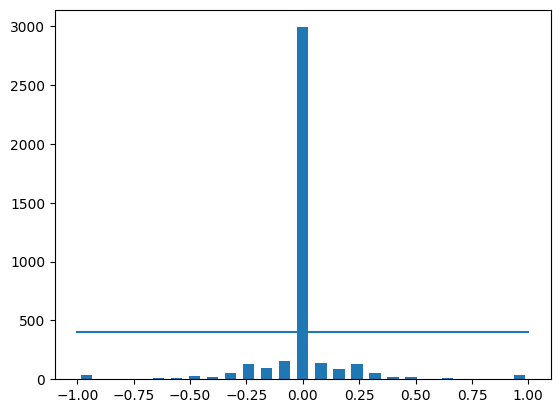

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

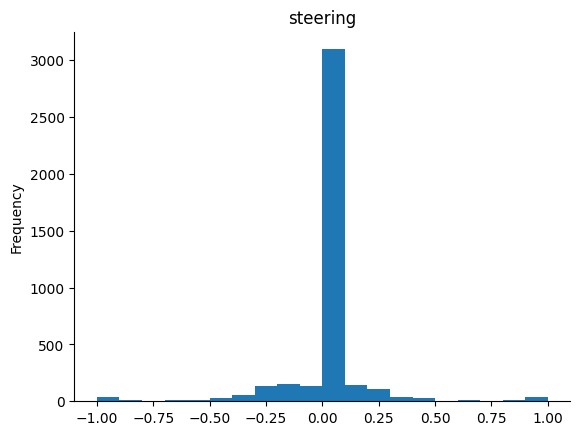

In [ ]:
# @title steering

from matplotlib import pyplot as plt
data['steering'].plot(kind='hist', bins=20, title='steering')
plt.gca().spines[['top', 'right',]].set_visible(False)

total data 4053
removed 2590
remaining: 1463


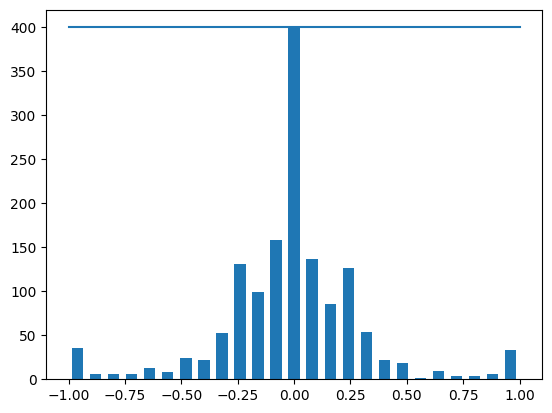

In [ ]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [ ]:
def load_image_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)
print(image_paths.shape)
print(steerings.shape)

(1463,)
(1463,)


In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training data: {}\nValid data: {}'.format(len(X_train),len(X_valid)))


Training data: 1170
Valid data: 293


Text(0.5, 1.0, 'valid set')

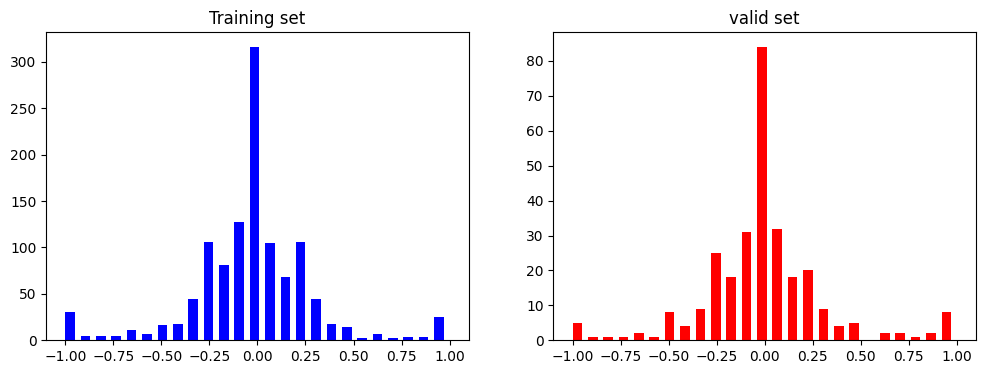

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (12,4))
axs[0].hist(Y_train, bins = num_bins, width = 0.05, color = 'b')
axs[0].set_title('Training set')
axs[1].hist(Y_valid, bins = num_bins, width = 0.05, color = 'r')
axs[1].set_title('valid set')

In [ ]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [ ]:
def image_preprocessing(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = image_preprocessing(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))


In [ ]:
X_train_gen, Y_train_gen = next(batch_generator(X_train, Y_train, 1, 1))
X_valid_gen, Y_valid_gen = next(batch_generator(X_valid, Y_valid, 1, 0))

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5,5), strides = (2,2), input_shape = (66, 200, 3), activation= 'elu'))
  model.add(Conv2D(36, (5,5), strides = (2,2), activation= 'elu'))
  model.add(Conv2D(48, (5,5), strides = (2,2), activation= 'elu'))
  model.add(Conv2D(64, (5,5), activation= 'elu'))
  model.add(Flatten())
  model.add(Dense(100, activation= 'elu'))
  model.add(Dense(50, activation= 'elu'))
  model.add(Dense(10, activation= 'elu'))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)

  return model


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
from keras.optimizers import Adam

model = nvidia_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 18, 64)         76864     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               115300    
                                                                 
 dense_1 (Dense)             (None, 50)               

In [ ]:
 h = model.fit_generator(batch_generator(X_train, Y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, Y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)


<ipython-input-26-46386bf0c014>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(batch_generator(X_train, Y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 121s 381ms/step - loss: 0.1136 - val_loss: 0.1030
Epoch 2/10
300/300 [==============================] - 126s 422ms/step - loss: 0.0949 - val_loss: 0.0709
Epoch 3/10
300/300 [==============================] - 111s 372ms/step - loss: 0.0648 - val_loss: 0.0585
Epoch 4/10
300/300 [==============================] - 113s 379ms/step - loss: 0.0525 - val_loss: 0.0438
Epoch 5/10
300/300 [==============================] - 121s 403ms/step - loss: 0.0457 - val_loss: 0.0380
Epoch 6/10
300/300 [==============================] - 118s 396ms/step - loss: 0.0395 - val_loss: 0.0368
Epoch 7/10
300/300 [==============================] - 120s 401ms/step - loss: 0.0366 - val_loss: 0.0441
Epoch 8/10
300/300 [==============================] - 107s 358ms/step - loss: 0.0344 - val_loss: 0.0349
Epoch 9/10
300/300 [==============================] - 135s 450ms/step - loss: 0.0325 - val_loss: 0.0302
Epoch 10/10
300/300 [==============================] - 132s 441m

In [ ]:
model.save('model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>